In [1]:
import numpy as np
from random import *
import matplotlib.pyplot as plt
from qutip import *

Defining the needed functions

In [7]:
def coin_toss(s, C, l):
    return tensor(C, qeye(2 * l + 1)) * s


def shift_operator(s, l):
    S = tensor(
        (basis(2, 0) * basis(2, 0).dag()),
        sum(
            [
                (basis(2 * l + 1, p + 1) * basis(2 * l + 1, p).dag())
                for p in range(2 * l)
            ]
        )
        + basis(2 * l + 1, 0) * basis(2 * l + 1, 2 * l).dag(),
    ) + tensor(
        (basis(2, 1) * basis(2, 1).dag()),
        sum(
            [
                (basis(2 * l + 1, p - 1) * basis(2 * l + 1, p).dag())
                for p in range(1, 2 * l + 1)
            ]
        )
        + basis(2 * l + 1, 2 * l) * basis(2 * l + 1, 0).dag(),
    )
    return S * s


def measurement_op_j_up(j, l):
    # normalization = 2 * (2 * l + 1)
    return (
        tensor(
            basis(2, 0) * basis(2, 0).dag(),
            basis(2 * l + 1, j) * basis(2 * l + 1, j).dag(),
        )
        # / normalization
    )


def measurement_op_j_down(j, l):
    # normalization = 2 * (2 * l + 1)
    return (
        tensor(
            basis(2, 1) * basis(2, 1).dag(),
            basis(2 * l + 1, j) * basis(2 * l + 1, j).dag(),
        )
        # / normalization
    )


def measurement_j(j, l):
    return measurement_op_j_up(j, l).dag() * measurement_op_j_up(
        j, l
    ) + measurement_op_j_down(j, l).dag() * measurement_op_j_down(j, l)


def get_probability_j(j, l, s):
    return s.dag() * measurement_j(j, l) * s

Initializing the cycle and defining the hamiltonian

In [2]:
L = 5
H = (1 / np.sqrt(2)) * Qobj([[1, 1], [1, -1]])
init_pos = basis(2 * L + 1, int(L))
init_coin = (1 / np.sqrt(2)) * (basis(2, 0) + basis(2, 1) * complex(0, 1))
init_state = tensor(init_coin, init_pos)


Defining the function to get the probability distribution on vertexes averaged over time

In [4]:
def get_PT(time, l, init_s, coin):
    P_t = []
    n_s = init_s
    for t in range(0, time):
        n_s = coin_toss(n_s, coin, l)
        n_s = shift_operator(n_s, l)
        P_t_buff = []
        for i in range(2 * l + 1):
            P_t_buff.append(get_probability_j(i, l, n_s).full())
        P_t.append(P_t_buff)
    P_T = [sum(x) for x in zip(*P_t)]
    for i in range(2 * l + 1):
        P_T[i] = P_T[i] / time
    return P_T

pi = []
for i in range(2 * L + 1):
    pi.append(1 / (2 * L + 1))

Draw the probability distribution averaged over time

In [5]:
def draw_(time, l, coin):
    x = []
    for i in range(2 * l + 1):
        x.append(i)
    i_p = basis(2 * l + 1, int(l))
    i_c = (1 / np.sqrt(2)) * (basis(2, 0) + basis(2, 1) * complex(0, 1))
    i_s = tensor(i_c, i_p)
    P_T = get_PT(time, l, i_s, coin)
    y2 = []
    for i in P_T:
        y2.append(np.real(i[0]))

    y3 = []
    for i in y2:
        y3.append(i[0])
    p = []
    for i in range(2 * l + 1):
        p.append(1 / (2 * l + 1))
    fig, ax = plt.subplots()
    ax.plot(x, y3, label="Probability distribution", color="blue")
    ax.plot(x, p, "k:", label="Limit distribution", color="red")
    legend = ax.legend(loc="upper center")
    legend.get_frame().set_facecolor("C0")
    # plt.plot(Ns, y)
    plt.xlabel("Number of vertexes")
    plt.ylabel("Mixing Time")
    plt.ylim(0, 1)
    plt.show()

/var/folders/jk/jgkdl6hx493bhb_hd6fkl9q00000gn/T/ipykernel_26949/3332223184.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, p, "k:", label="Limit distribution", color="red")


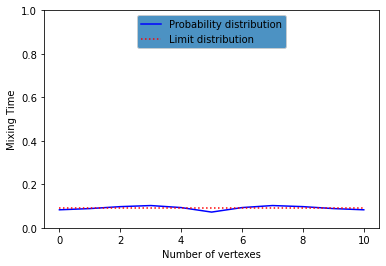

In [8]:
draw_(30,5,H)

Mixing time

In [9]:
def variation_distance(a, b):
    ab = []
    for i in range(len(a)):
        ab.append(abs(a[i] - b[i]))
    return sum(ab)


def calc_mixing_time(b, c, s, T, epsilon, l):
    loops = 0
    for t in range(1, T):
        PT = get_PT(t, l, s, c)
        if variation_distance(PT, b) <= epsilon:
            return int(t)
        else:
            loops += 1
            if loops == T - 1:
                return int(-1)
            else:
                pass


def mixing_times():
    Ls = [(2 * i + 1) for i in range(2, 10, 1)]
    T = 10000
    y = []
    for i in Ls:
        i_p = basis(2 * i + 1, int(i))
        i_c = (1 / np.sqrt(2)) * (basis(2, 0) + basis(2, 1) * complex(0, 1))
        i_s = tensor(i_c, i_p)
        epss = 0.1
        pis = []
        for j in range(2 * i + 1):
            pis.append(1 / (2 * i + 1))
        y.append(calc_mixing_time(pis, H, i_s, T, epss, i))
    with open("data_QW_C,txt", "w") as f:
        for i in range(len(Ls)):
            f.write(str(Ls[i]))
            f.write(",")
            f.write(str(y[i]))
            f.write("\n")

    ub = []
    for i in Ls:
        ub.append(((2 * i + 1) * np.log(2 * i + 1)) / (0.1 * 0.1 * 0.1))
    fig, ax = plt.subplots()
    ax.plot(Ls, y, label="Computed mixing time", color="blue")
    ax.plot(Ls, ub, "k:", label="Upper bound", color="red")
    # ax.plot(Ns, theta, "k:", label="Expected", color="pink")
    legend = ax.legend(loc="upper center")
    legend.get_frame().set_facecolor("C0")
    # plt.plot(Ns, y)
    plt.grid(linestyle="--", linewidth=0.5)
    plt.xlabel("Number of vertexes")
    plt.ylabel("Mixing Time")
    plt.show()

/var/folders/jk/jgkdl6hx493bhb_hd6fkl9q00000gn/T/ipykernel_26949/1301461332.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  ax.plot(Ls, ub, "k:", label="Upper bound", color="red")


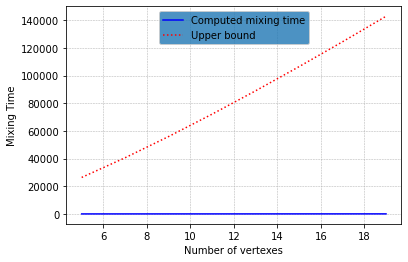

In [10]:
mixing_times()